In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
# from sklearn.preprocessing import MinMaxScaler

In [2]:
gpus = tf.config.list_physical_devices(device_type = 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
class DataLoader:
    def __init__(self):
        AS_dataset = pd.read_csv('./Dualbad_Coupler_40000_10_60.csv', encoding='utf-8')
        self.X = AS_dataset.loc[:,'freq':'L2'].to_numpy(dtype = np.float32)
        self.y = AS_dataset.loc[:,'S11r':'S41i'].to_numpy(dtype = np.float32)
#         self.mmX = MinMaxScaler()
#         self.X[:,1:] = self.mmX.fit_transform(self.X[:,1:])
        # self.X[:,0] = self.X[:,0] * 10
        # self.X_train, self.X_vali, self.y_train, self.y_vali = train_test_split(self.X, self.y, test_size=0.01, random_state=0)
        self.X_train, self.y_train = self.X, self.y
        self.num_train = self.X_train.shape[0]
    def get_batch(self, batch_size=0, mode='train'):
        if mode == 'train':
            index = np.random.randint(0, self.num_train, batch_size)
            return self.X_train[index], self.y_train[index]
        if mode == 'validate':
            return self.X_vali, self.y_vali

In [4]:
class MLP(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # self.emb = tf.keras.layers.Embedding(100, 128)
        # self.dense0 = tf.keras.layers.Dense(units=8, activation=tf.nn.leaky_relu)
        self.dense1 = tf.keras.layers.Dense(units=128, activation=tf.nn.leaky_relu)
        self.dense2 = tf.keras.layers.Dense(units=1024, activation=tf.nn.leaky_relu)
        self.dense3 = tf.keras.layers.Dense(units=128, activation=tf.nn.leaky_relu)
        self.dense4 = tf.keras.layers.Dense(units=1024, activation=tf.nn.leaky_relu)
        self.dense5 = tf.keras.layers.Dense(units=8)
    
#     @tf.function
    def call(self, inputs, freq):
        # f_emb = self.emb(freq)
        # x = self.dense1(inputs + tf.squeeze(self.dense0(f_emb)))
        x = self.dense1(tf.concat([freq, inputs], axis = 1))
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        output = self.dense5(x)
        return output

In [5]:
num_epochs = 50
batch_size = 1024
learning_rate = 0.001

In [6]:
model = MLP()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
data_loader = DataLoader()
# X_vali, y_vali = data_loader.get_batch(mode='validate')
GT_struct = tf.constant([1.63247, 1.84619, 2.01675, 1.66595, 14.7001, 13.5447, 14.653, 11.2898])
S_t, f_t = tf.tile([GT_struct], [10, 1]), tf.constant([[2.0], [2.1], [2.2], [2.3], [2.4], [5.0], [5.1], [5.2], [5.3], [5.4]])
GT_S = tf.constant([[0.12,0.394,-0.196,-0.27,-0.733,-0.071,-0.179,-0.36],
[0.191,0.22,-0.21,-0.21,-0.764,0.16,-0.24,-0.374],
[0.163,0.008,-0.185,-0.16,-0.681,0.422,-0.344,-0.362],
[0.021,-0.164,-0.144,-0.163,-0.464,0.629,-0.46,-0.278],
[-0.179,-0.235,-0.156,-0.211,-0.175,0.706,-0.521,-0.13],
[0.256,-0.007,-0.353,-3.56E-04,-0.277,0.716,-0.385,0.208],
[0.124,-0.087,-0.287,0.058,-0.055,0.814,-0.381,0.221],
[-0.043,-0.082,-0.205,0.054,0.198,0.805,-0.394,0.271],
[-0.176,0.006,-0.164,-0.005,0.407,0.692,-0.377,0.356],
[-0.242,0.131,-0.186,-0.065,0.533,0.536,-0.315,0.434]])

epoch:0
train mse:0.03300213813781738 rmse:0.18166489899158478 mae:0.1376168578863144 r2:0.7292224168777466 EC:0.6920835971832275
GT mse:0.030253032222390175 rmse:0.1739339828491211 mae:0.13304558396339417 r2:0.7490007877349854
epoch:10
train mse:0.006496735382825136 rmse:0.08060232549905777 mae:0.058163732290267944 r2:0.9468716979026794 EC:0.8916916251182556
GT mse:0.005155289079993963 rmse:0.0718003436923027 mae:0.05476413294672966 r2:0.9572283029556274
epoch:20
train mse:0.0040081702172756195 rmse:0.06331010907888412 mae:0.041830580681562424 r2:0.9670846462249756 EC:0.9381599426269531
GT mse:0.0021925722248852253 rmse:0.04682490974664688 mae:0.03345033526420593 r2:0.9818089604377747
epoch:30
train mse:0.003355264663696289 rmse:0.05792464688420296 mae:0.039042651653289795 r2:0.9725457429885864 EC:0.9644668102264404
GT mse:0.0011512155178934336 rmse:0.03392956778407097 mae:0.02721984311938286 r2:0.9904487729072571
epoch:40
train mse:0.0020515196956694126 rmse:0.04529370367527008 mae:0

ValueError: x and y must have same first dimension, but have shapes (21,) and (6,)

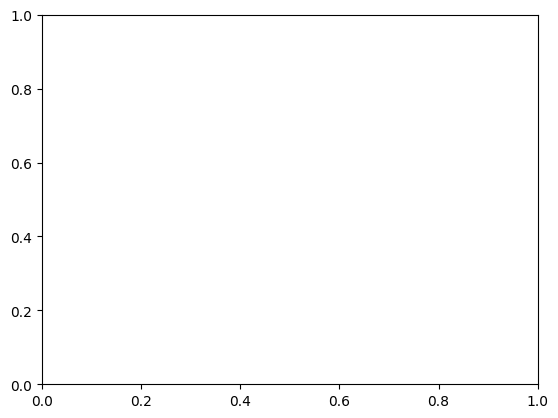

In [7]:
showX = [0, 10, 20, 30, 40, 49]
showY1 = []
showY2 = []
num_batch = data_loader.num_train // batch_size
for epoch_index in range(num_epochs):
    for batch in range(num_batch):
        X, y = data_loader.get_batch(batch_size)
        with tf.GradientTape() as tape:
            y_pred = model(X[:,1:], X[:,:1])
            tr_mse = tf.reduce_mean(tf.square(y_pred - y))
        grads = tape.gradient(tr_mse, model.variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
    if epoch_index % 10 == 0 or epoch_index == num_epochs - 1:
        tr_EC = tf.reduce_mean(tf.reduce_sum(tf.square(y_pred), axis=1))
        tr_rmse = tf.sqrt(tr_mse)
        tr_mae = tf.reduce_mean(tf.abs(y_pred - y))
        tr_r2 = 1 - tf.reduce_sum(tf.square(y_pred - y)) / tf.reduce_sum(tf.square(y - tf.reduce_mean(y)))
        print("epoch:{}".format(epoch_index))
        print("train mse:{} rmse:{} mae:{} r2:{} EC:{}".format(tr_mse, tr_rmse, tr_mae, tr_r2, tr_EC))
        # y_v_p = model(X_vali[:,1:], X_vali[:,:1])
        # va_mse = tf.reduce_mean(tf.square(y_v_p - y_vali))
        # va_rmse = tf.sqrt(va_mse)
        # va_mae = tf.reduce_mean(tf.abs(y_v_p - y_vali))
        # va_r2 = 1 - tf.reduce_sum(tf.square(y_v_p - y_vali)) / tf.reduce_sum(tf.square(y_vali - tf.reduce_mean(y_vali)))
        # print("vali mse:{} rmse:{} mae:{} r2:{}".format(va_mse, va_rmse, va_mae, va_r2))
        GT_y = model(S_t, f_t)
        # GT_loss = loss_func(GT_y[0:1], GT_y[1:2], GT_y[2:3], GT_y[3:4], GT_y[4:5], GT_y[5:6]) + loss_func(GT_y[6:7], GT_y[7:8], GT_y[8:9], GT_y[9:10], GT_y[10:11], GT_y[11:12])
        GT_mse = tf.reduce_mean(tf.square(GT_y - GT_S))
        GT_rmse = tf.sqrt(GT_mse)
        GT_mae = tf.reduce_mean(tf.abs(GT_y - GT_S))
        GT_r2 = 1 - tf.reduce_sum(tf.square(GT_y - GT_S)) / tf.reduce_sum(tf.square(GT_S - tf.reduce_mean(GT_S)))
        print("GT mse:{} rmse:{} mae:{} r2:{}".format(GT_mse, GT_rmse, GT_mae, GT_r2))
        showY1.append(tr_r2)
        # showY2.append(va_r2)
plt.plot(showX, showY1)
# plt.plot(showX, showY2)
plt.ylim(0, 1)
plt.show()

In [14]:
tf.saved_model.save(model, './models')

INFO:tensorflow:Assets written to: ./models/assets


In [7]:
model = tf.saved_model.load('./models')

In [8]:
def dgn_obj(s_para, dis = False):
    E = tf.square(s_para)
    E31 = E[:,4] + E[:,5]
    E41 = E[:,6] + E[:,7]
    # l1 = tf.square(E31 - 0.691)
    # l2 = tf.square(E41 - 0.295)
    l1 = tf.square(E31 - 0.681)
    l2 = tf.square(E41 - 0.285)
    if dis == True:
        print("l1", l1.numpy()[0])
        print("l2", l2.numpy()[0])
    return l1 + l2
def loss_func(s1, s2, s3, s4, s5, dis = False):
    var = tf.reduce_sum(tf.nn.moments(tf.stack([s1, s2, s3, s4, s5], axis=1), [1])[1][:, 4: 8], axis=-1)
    if dis == True:
        print("var", var.numpy()[0])
    return var * 0.2 + dgn_obj(s1, dis) + dgn_obj(s2, dis) + dgn_obj(s3, dis) + dgn_obj(s4, dis) + dgn_obj(s5, dis)

In [56]:
# def dgn_obj(s_para, dis = False):
#     E = tf.square(s_para)
#     E11 = E[:,0] + E[:,1]
#     E21 = E[:,2] + E[:,3]
#     E31 = E[:,4] + E[:,5]
#     E41 = E[:,6] + E[:,7]
#     l1 = E11 + E21 - E31 - E41
#     l2 = tf.abs(E31 / (E31 + E41) - 0.7)
#     # l3 = tf.abs(tf.math.atan2(s_para[:,3], s_para[:,2]) - tf.math.atan2(s_para[:,5], s_para[:,4]) - np.pi / 4)
#     l4 = tf.abs(tf.reduce_sum(E, axis=1) - 1)
#     loss = l1 * 0.6 + l2 * 1.4 + l4
#     if dis == True:
#         print("l1", l1.numpy()[0], "W l1", l1.numpy()[0] * 0.5)
#         print("l2", l2.numpy()[0],  "W l2", l4.numpy()[0] * 1.5)
#         # print("l3", l3.numpy()[0])
#         print("l4", l4.numpy()[0],  "W l4", l4.numpy()[0])
#     return loss
# def loss_func(s1, s2, s3, s4, s5, dis = False):
#     # 31和41的方差
#     var = tf.reduce_sum(tf.nn.moments(tf.stack([s1, s2, s3, s4, s5], axis=1), [1])[1][:, 4: 8], axis=-1)
#     if dis == True:
#         print("var", var.numpy()[0],  "W var", var.numpy()[0] * 1.5)
#     return var * 2 + dgn_obj(s1, dis) + dgn_obj(s2, dis) + dgn_obj(s3, dis) + dgn_obj(s4, dis) + dgn_obj(s5, dis)

In [9]:
num_nodes = 10000
num_node_epochs = 1000

In [16]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)

mmin = np.min(data_loader.X[: , 1: ], axis=0)
mmax = np.max(data_loader.X[: , 1: ], axis=0)

# structure.append(tf.Variable(np.random.uniform(0, 1, (num_nodes, 10)), dtype=tf.float32))
structure = tf.Variable(np.random.uniform(mmin, mmax, (num_nodes, 8)), dtype=tf.float32)

freq20 = tf.ones([num_nodes, 1]) * 2.0
freq21 = tf.ones([num_nodes, 1]) * 2.1
freq22 = tf.ones([num_nodes, 1]) * 2.2
freq23 = tf.ones([num_nodes, 1]) * 2.3
freq24 = tf.ones([num_nodes, 1]) * 2.4

freq50 = tf.ones([num_nodes, 1]) * 5.0
freq51 = tf.ones([num_nodes, 1]) * 5.1
freq52 = tf.ones([num_nodes, 1]) * 5.2
freq53 = tf.ones([num_nodes, 1]) * 5.3
freq54 = tf.ones([num_nodes, 1]) * 5.4

In [17]:
bestLoss = 1000
bestStructure = 0

In [18]:
def check(structure):
    inva_place1 = tf.where(tf.logical_or(structure[:,:4] < 1, structure[:,:4] > 5))
    structure = tf.tensor_scatter_nd_update(structure, [inva_place1], [np.random.uniform(mmin[inva_place1[:,1]], mmax[inva_place1[:,1]], (inva_place1.shape[0]))])
    
    inva_place2 = tf.where(tf.logical_or(structure[:,4:6] < 2, structure[:,4:6] > 22)) + [0, 4]
    structure = tf.tensor_scatter_nd_update(structure, [inva_place2], [np.random.uniform(mmin[inva_place2[:,1]], mmax[inva_place2[:,1]], (inva_place2.shape[0]))])
    
    inva_place3 = tf.where(tf.logical_or(structure[:,6:8] < 4, structure[:,6:8] > 44)) + [0, 6]
    structure = tf.tensor_scatter_nd_update(structure, [inva_place3], [np.random.uniform(mmin[inva_place3[:,1]], mmax[inva_place3[:,1]], (inva_place3.shape[0]))])
    
    return tf.Variable(structure)
    
    # structure[j] = tf.Variable(tf.tensor_scatter_nd_update(structure[j], [nega_place], [np.random.uniform(0, 1, (nega_place.shape[0]))]))

In [19]:
for i in range(num_node_epochs):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(structure)
        y_pred20 = model(structure, freq20)
        y_pred21 = model(structure, freq21)
        y_pred22 = model(structure, freq22)
        y_pred23 = model(structure, freq23)
        y_pred24 = model(structure, freq24)

        y_pred50 = model(structure, freq50)
        y_pred51 = model(structure, freq51)
        y_pred52 = model(structure, freq52)
        y_pred53 = model(structure, freq53)
        y_pred54 = model(structure, freq54)
        
        loss = loss_func(y_pred20, y_pred21, y_pred22, y_pred23, y_pred24) + loss_func(y_pred50, y_pred51, y_pred52, y_pred53, y_pred54)
    minLoss = tf.reduce_min(loss).numpy()
    minIndex = tf.argmin(loss).numpy()
    minS = structure[minIndex].numpy()
    grads = tape.gradient(loss, structure)
    opt.apply_gradients(grads_and_vars=zip([grads], [structure]))
    structure = check(structure)
    if minLoss < bestLoss:
        bestLoss = minLoss
        bestStructure = minS
        # bestStructure = data_loader.mmX.inverse_transform([minS[0]])[0]
        print(minIndex)
        print(i, bestLoss)
        print(" ".join(map(str, bestStructure)))
        print()

1805
0 0.2782029
1.3447024 2.983912 2.1012144 3.0342693 4.199269 4.185712 10.215969 28.364996

1805
1 0.27017167
1.3347026 2.9739125 2.0912142 3.0442696 4.189269 4.1757116 10.205972 28.354996

1805
2 0.26472718
1.3272617 2.9664717 2.083773 3.0517108 4.181828 4.1682706 10.198532 28.347555

1805
3 0.26041874
1.320874 2.9600842 2.0773847 3.0580988 4.1754403 4.161883 10.192145 28.341167

1805
4 0.256899
1.315063 2.9542737 2.0715735 3.06391 4.169629 4.1560717 10.186335 28.335356

1805
5 0.25417623
1.3096085 2.9488196 2.0661187 3.0693648 4.1641746 4.150617 10.180881 28.3299

1805
6 0.25209713
1.3043877 2.9436014 2.0608976 3.0745857 4.1589537 4.145396 10.17566 28.32468

1805
7 0.2502914
1.2993243 2.938543 2.0558338 3.079649 4.15389 4.1403327 10.170597 28.319616

1805
8 0.2485885
1.2943671 2.9335895 2.0508764 3.084606 4.148933 4.1353755 10.165641 28.31466

1805
9 0.24710089
1.28948 2.9288082 2.045989 3.0894926 4.144046 4.1304884 10.160754 28.309772

1805
10 0.24562229
1.284636 2.933632 2.04114

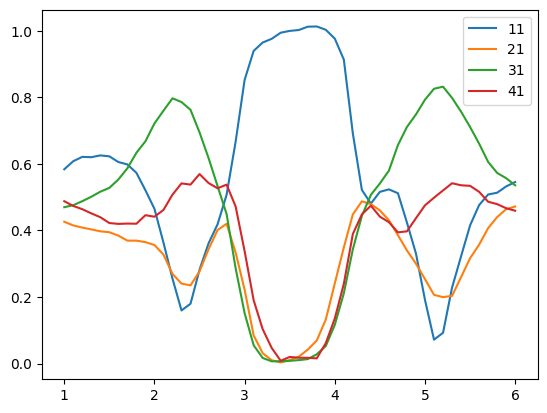

In [22]:
fig_freq = tf.linspace(1.0, 6.0, 51)
fig_x = tf.concat([tf.reshape(fig_freq, (-1, 1)), tf.tile([bestStructure], [51, 1])], axis=-1)
fig_y = model(fig_x[:,1:], fig_x[:,:1])
E = tf.square(fig_y)
M11 = tf.sqrt(E[:,0] + E[:,1])
M21 = tf.sqrt(E[:,2] + E[:,3])
M31 = tf.sqrt(E[:,4] + E[:,5])
M41 = tf.sqrt(E[:,6] + E[:,7])
plt.figure()
plt.plot(fig_freq, M11, label='11')
plt.plot(fig_freq, M21, label='21')
plt.plot(fig_freq, M31, label='31')
plt.plot(fig_freq, M41, label='41')
plt.legend()
plt.show()

In [26]:
# S4P
l = fig_y.numpy().tolist()
for i in range(len(l)):
    print(round(fig_freq.numpy()[i]*10,0), end="\t")
    print(l[i][0], l[i][1], "0\t" * 6, sep="\t")
    print(l[i][2], l[i][3], "0\t" * 6, sep="\t")
    print(l[i][4], l[i][5], "0\t" * 6, sep="\t")
    print(l[i][6], l[i][7], "0\t" * 6, sep="\t")

100.0	-0.5909846425056458	0.20429062843322754	0	0	0	0	0	0	
0.172169029712677	-0.39559206366539	0	0	0	0	0	0	
0.06947550922632217	-0.47631731629371643	0	0	0	0	0	0	
0.17739468812942505	-0.3540465831756592	0	0	0	0	0	0	
110.0	-0.5777656435966492	0.2603551745414734	0	0	0	0	0	0	
0.13542470335960388	-0.39899688959121704	0	0	0	0	0	0	
0.017769746482372284	-0.4883670508861542	0	0	0	0	0	0	
0.1379082053899765	-0.36502718925476074	0	0	0	0	0	0	
120.0	-0.5531373620033264	0.3120562434196472	0	0	0	0	0	0	
0.104515440762043	-0.3977598249912262	0	0	0	0	0	0	
-0.03327012062072754	-0.49799197912216187	0	0	0	0	0	0	
0.10354290902614594	-0.3728885352611542	0	0	0	0	0	0	
130.0	-0.5058783292770386	0.3702471852302551	0	0	0	0	0	0	
0.07947497814893723	-0.39745867252349854	0	0	0	0	0	0	
-0.10644733160734177	-0.5061553120613098	0	0	0	0	0	0	
0.05400608479976654	-0.3823881149291992	0	0	0	0	0	0	
140.0	-0.4640699028968811	0.4260299801826477	0	0	0	0	0	0	
0.0340283140540123	-0.39709746837615967	0	0	0	0	0	0	
-0.1834462285041809

In [63]:
MP_y = model(tf.tile([bestStructure], [10, 1]), f_t)
GT_y = model(S_t, f_t)

print("MP")
MP_loss = loss_func(MP_y[0:1], MP_y[1:2], MP_y[2:3], MP_y[3:4], MP_y[4:5], dis = True) + loss_func(MP_y[5:6], MP_y[6:7], MP_y[7:8], MP_y[8:9], MP_y[9:10], dis = True)
print(MP_loss)

print("GT")
GT_loss = loss_func(GT_y[0:1], GT_y[1:2], GT_y[2:3], GT_y[3:4], GT_y[4:5], dis = True) + loss_func(GT_y[5:6], GT_y[6:7], GT_y[7:8], GT_y[8:9], GT_y[9:10], dis = True)
print(GT_loss)

MP
var 0.11353853
l1 0.0007765375
l2 0.01540246
l1 6.6087466e-08
l2 0.0008472229
l1 0.0016470682
l2 0.00056490826
l1 0.011153789
l2 0.0002956983
l1 0.029106189
l2 0.0020094397
var 0.18328136
l1 0.03419086
l2 0.0016173398
l1 0.0032164236
l2 0.00052682124
l1 0.00020448456
l2 0.00047391217
l1 0.011448858
l2 0.010656408
l1 0.045881175
l2 0.021957844
tf.Tensor([0.2810235], shape=(1,), dtype=float32)
GT
var 0.16826381
l1 0.032510754
l2 0.021993604
l1 0.010938943
l2 0.017108776
l1 0.002537471
l2 0.002142768
l1 0.0013150303
l2 0.00080600847
l1 0.021698872
l2 0.0007083373
var 0.06887924
l1 0.10129388
l2 0.004120088
l1 0.074854426
l2 0.00036495045
l1 0.05123036
l2 0.0007233451
l1 0.038174078
l2 0.0071114697
l1 0.02539194
l2 0.0078924885
tf.Tensor([0.49406052], shape=(1,), dtype=float32)


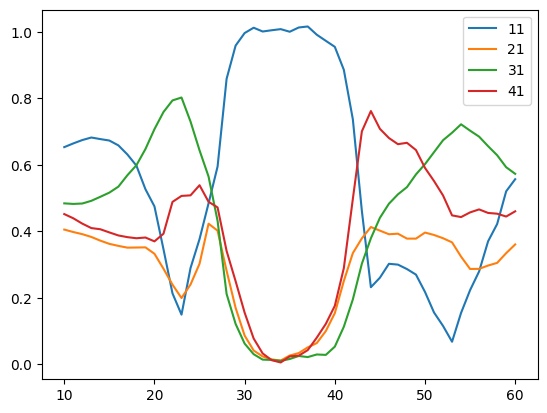

In [15]:
fig_freq = tf.linspace(10., 60, 51)
fig_x = tf.concat([tf.reshape(fig_freq, (-1, 1)), tf.tile([GT_struct], [51, 1])], axis=-1)
fig_y = model(fig_x[:,1:], fig_x[:,:1])
E = tf.square(fig_y)
M11 = tf.sqrt(E[:,0] + E[:,1])
M21 = tf.sqrt(E[:,2] + E[:,3])
M31 = tf.sqrt(E[:,4] + E[:,5])
M41 = tf.sqrt(E[:,6] + E[:,7])
plt.figure()
plt.plot(fig_freq, M11, label='11')
plt.plot(fig_freq, M21, label='21')
plt.plot(fig_freq, M31, label='31')
plt.plot(fig_freq, M41, label='41')
plt.legend()
plt.show()